# 02_peptide_level_analysis

In [1]:
from pigeon_feather.data import *
from pigeon_feather.plot import *
from pigeon_feather.hxio import *
from pigeon_feather.spectra import *


import numpy as np
import pandas as pd

import datetime
import os
import pickle
import datetime

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


In [2]:
# load the pickle file we saved in the previous notebook
today = datetime.date.today().strftime("%Y%m%d")
today = "20240722"

with open(f"./data/hdxms_data_raw_{today}.pkl", "rb") as f:
    hdxms_data_list = pickle.load(f)


# back exchange correction for peptides with experimental full deuteration data based its closest match in the database
tools.backexchange_correction(hdxms_data_list)

Number of peptides with experimental max_d: 358
Number of peptides with no experimental max_d: 12


In [3]:
# make folders for results

out_path = "./data/PF_input_20240722"

today_date = datetime.date.today().strftime("%Y%m%d")
# today_date = '20240722'
results_path = f"ecDHFR_results_{today_date}"

if not os.path.exists(results_path):
    os.makedirs(results_path)

## uptake plots

In [4]:
# option 1
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.ticker as ticker
import matplotlib.lines as mlines
from pigeon_feather.analysis import get_index_offset
from matplotlib.ticker import LogLocator


font = {"family": "Arial", "weight": "normal", "size": 36}
axes = {"titlesize": 36, "titleweight": "bold", "labelsize": 36, "linewidth": 5}
plt.rc("font", **font)
plt.rc("axes", **axes)
plt.rc("lines", lw=5)

colors = ["k", "red", "blue", "purple", "gray", "orange", "yellow", "green", "brown"]


all_peps = [
    peptide
    for hdxms_data in hdxms_data_list
    for state in hdxms_data.states
    for peptide in state.peptides
    if peptide.note is None and state.state_name != "RAT"
]
all_idfs = [pep for pep in all_peps if pep.unique_num_timepoints > 5]
all_idfs = list(set([peptide.identifier for peptide in all_peps]))[:]
all_idfs.sort(key=lambda x: int(re.search(r"(-?\d+)", x).group()))



def idf_to_pep(idf):
    return [pep for pep in all_peps if pep.identifier == idf][0]

# num_subplots_per_figure = 100
num_subplots_per_figure = 250
num_figures = math.ceil(len(all_idfs) / num_subplots_per_figure)


all_idfs_subset = all_idfs[:]

for fig_index in range(num_figures):
    # Select the subset of errors for the current figure
    selected_idf = all_idfs_subset[
        fig_index * num_subplots_per_figure : (fig_index + 1) * num_subplots_per_figure
    ]
    num_col = math.ceil(len(selected_idf) / 5)

    fig, axs = plt.subplots(
        num_col, 5, figsize=(9 * 5, 8 * num_col)
    )  # Adjust subplot size as needed

    for i, idf in enumerate(selected_idf):
        ax = axs[i // 5, i % 5]


        pep = idf_to_pep(idf)
        ax.axhline(y=pep.max_d, color='lightgray', linestyle='--', linewidth=5)


        uptake = UptakePlot(
            hdxms_data_list,
            idf,
            states_subset=["APO", "TRI"],
            if_plot_fit=False,
            figure=fig,
            ax=ax,
        )

        ax.set_xlim(1e1, 1e5)
        ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=5))


        y_max = pep.theo_max_d/hdxms_data_list[0].saturation
        ax.set_ylim(-0.5, y_max + 0.5)


        #Custom legend
        handles, labels = ax.get_legend_handles_labels()
        new_labels = [label for label in labels if label in ["APO", "TRI"]]
        new_handles = [
            handle
            for handle, label in zip(handles, labels)
            if label in ["APO", "TRI"]  
        ]
        ax.legend(new_handles, new_labels, title="state", title_fontsize="small",loc='best')


    # Layout adjustment and save
    fig.tight_layout()
    fig.savefig(f"{results_path}/DHFR_exp_uptake_{fig_index}.pdf")

## pipetide comparison

Since the peptide-level comparison can only happen at the same time point between different states, let's group timepoints within 50 seconds as the same timepoint.


In [5]:
all_peptides = [
    peptide
    for hdxms_data in hdxms_data_list
    for state in hdxms_data.states
    for peptide in state.peptides
]


all_tps = [
    tp
    for pep in all_peptides
    for tp in pep.timepoints
    if tp.deut_time != np.inf and tp.deut_time != 0
]

tps_range = list(set([tp.deut_time for tp in all_tps]))


# Step 1: Sort the values
sorted_values = sorted(tps_range)

# Step 2: Group values with offsets less than 50
groups = []
current_group = []

for value in sorted_values:
    if current_group and value - current_group[-1] > 50:
        groups.append(current_group)
        current_group = []
    current_group.append(value)

# Add the last group if not empty
if current_group:
    groups.append(current_group)

# Step 3: Calculate average and map values to the average integer
result_mapping = {}
for group in groups:
    average = int(round(sum(group) / len(group)))
    for value in group:
        result_mapping[value] = average

result_mapping


for tp in all_tps:
    tp.deut_time = result_mapping[tp.deut_time]

`HDXStatePeptideCompares` can be created between two different states for comparison. It is a collection of all possible `HDXStatePeptideCompare`, where the same peptides are in both Proteinstate. HDXStatePeptideCompare
will find all the common timepoints and get the difference in D uptake. 

In [6]:
state1 = 'APO'
state2 = 'TRI'

# first get the states
state1_list = [i.get_state(state1) for i in hdxms_data_list]
state2_list = [i.get_state(state2) for i in hdxms_data_list]

pep_compres = HDXStatePeptideCompares(state1_list, state2_list)
pep_compres.add_all_compare()

In [7]:
# check the results
for i in pep_compres.peptide_compares[:10]:
    print('-----------------')
    print(i.compare_info)
    print(i.common_timepoints)
    print(i.deut_diff)
    

-----------------
APO-TRI: 12-19 LYFQSISL
[    0.    46.   374.   572.  2011.  7772. 30812. 43292.    inf]
[ 0.   -4.73 -1.3  -0.29  5.06  9.5  18.34 17.01  0.  ]
-----------------
APO-TRI: 13-19 YFQSISL
[    0.    46.   374.   572.  2011.  7772. 30812. 43292.    inf]
[ 0.   -2.57 -2.44  1.23  4.42 11.45 19.75 17.73  0.  ]
-----------------
APO-TRI: 14-19 FQSISL
[    0.    46.   374.   572.  2011.  7772. 30812. 43292.    inf]
[ 0.   -1.09 -1.89  0.65  3.5  12.59 24.48 21.75  0.  ]
-----------------
APO-TRI: 15-19 QSISL
[    0.    46.   374.   572.  2011.  7772. 30812. 43292.    inf]
[ 0.   -0.61 -1.31  2.52  5.73 16.05 27.09 24.22  0.  ]
-----------------
APO-TRI: 15-20 QSISLI
[    0.    46.   374.   572.  2011.  7772. 30812. 43292.    inf]
[ 0.   -1.09 -1.89  0.65  3.5  14.26 24.48 21.75  0.  ]
-----------------
APO-TRI: 15-16 QS
[    0.    46.   374.   572.  2011.  7772. 30812. 43292.    inf]
[  0.    -0.76 -11.12   3.54  -1.2   -0.19  -0.25  -2.84   0.  ]
-----------------
APO-TRI: 

## pseudo residue compare

pseudo residue compare is a comparison of the average D uptake between two different `Proteinstate` of all the peptides that cover this residue. D here is the normalized values based on the full-D experiments (0-100)

In [8]:
res_compares = HDXStateResidueCompares([i for i in range(1, 320)], state1_list, state2_list)
res_compares.add_all_compare()

In [9]:
# check the results
# deut_diff is the average deuteration difference of all peptides covering the residue
for i in res_compares.residue_compares[:5]:
    print('-----------------')
    print(i.compare_info)
    print(i.common_timepoints)
    print(i.deut_diff)
    

-----------------
APO-TRI: 12
[    0.    46.   374.   572.  2011.  7772. 30812. 43292.    inf]
[ 0.   -4.73 -1.3  -0.29  5.06  9.5  18.34 17.01  0.  ]
-----------------
APO-TRI: 13
[    0.    46.   374.   572.  2011.  7772. 30812. 43292.    inf]
[ 0.    -3.65  -1.87   0.47   4.74  10.475 19.045 17.37   0.   ]
-----------------
APO-TRI: 14
[    0.    46.   374.   572.  2011.  7772. 30812. 43292.    inf]
[ 0.         -2.79666667 -1.87666667  0.53        4.32666667 11.18
 20.85666667 18.83        0.        ]
-----------------
APO-TRI: 15
[    0.    46.   374.   572.  2011.  7772. 30812. 43292.    inf]
[ 0.         -1.80833333 -3.325       1.38333333  3.50166667 10.61
 18.98166667 16.60333333  0.        ]
-----------------
APO-TRI: 16
[    0.    46.   374.   572.  2011.  7772. 30812. 43292.    inf]
[ 0.         -1.47714286 -2.90428571  1.55857143  3.95571429 11.69571429
 20.75428571 18.39142857  0.        ]


## visualization on pymol structure

Both comparison objects can be projected to a pdb structure for Visualization

In [10]:
# both of the compare objects can be exported as a pymol pse file for visualization
pdb_file = 'data/6XG5_TRI.pdb'

create_compare_pymol_plot(pep_compres, colorbar_max=20, pdb_file=pdb_file, path=f'{results_path}')
create_compare_pymol_plot(res_compares, colorbar_max=20, pdb_file=pdb_file, path=f'{results_path}')

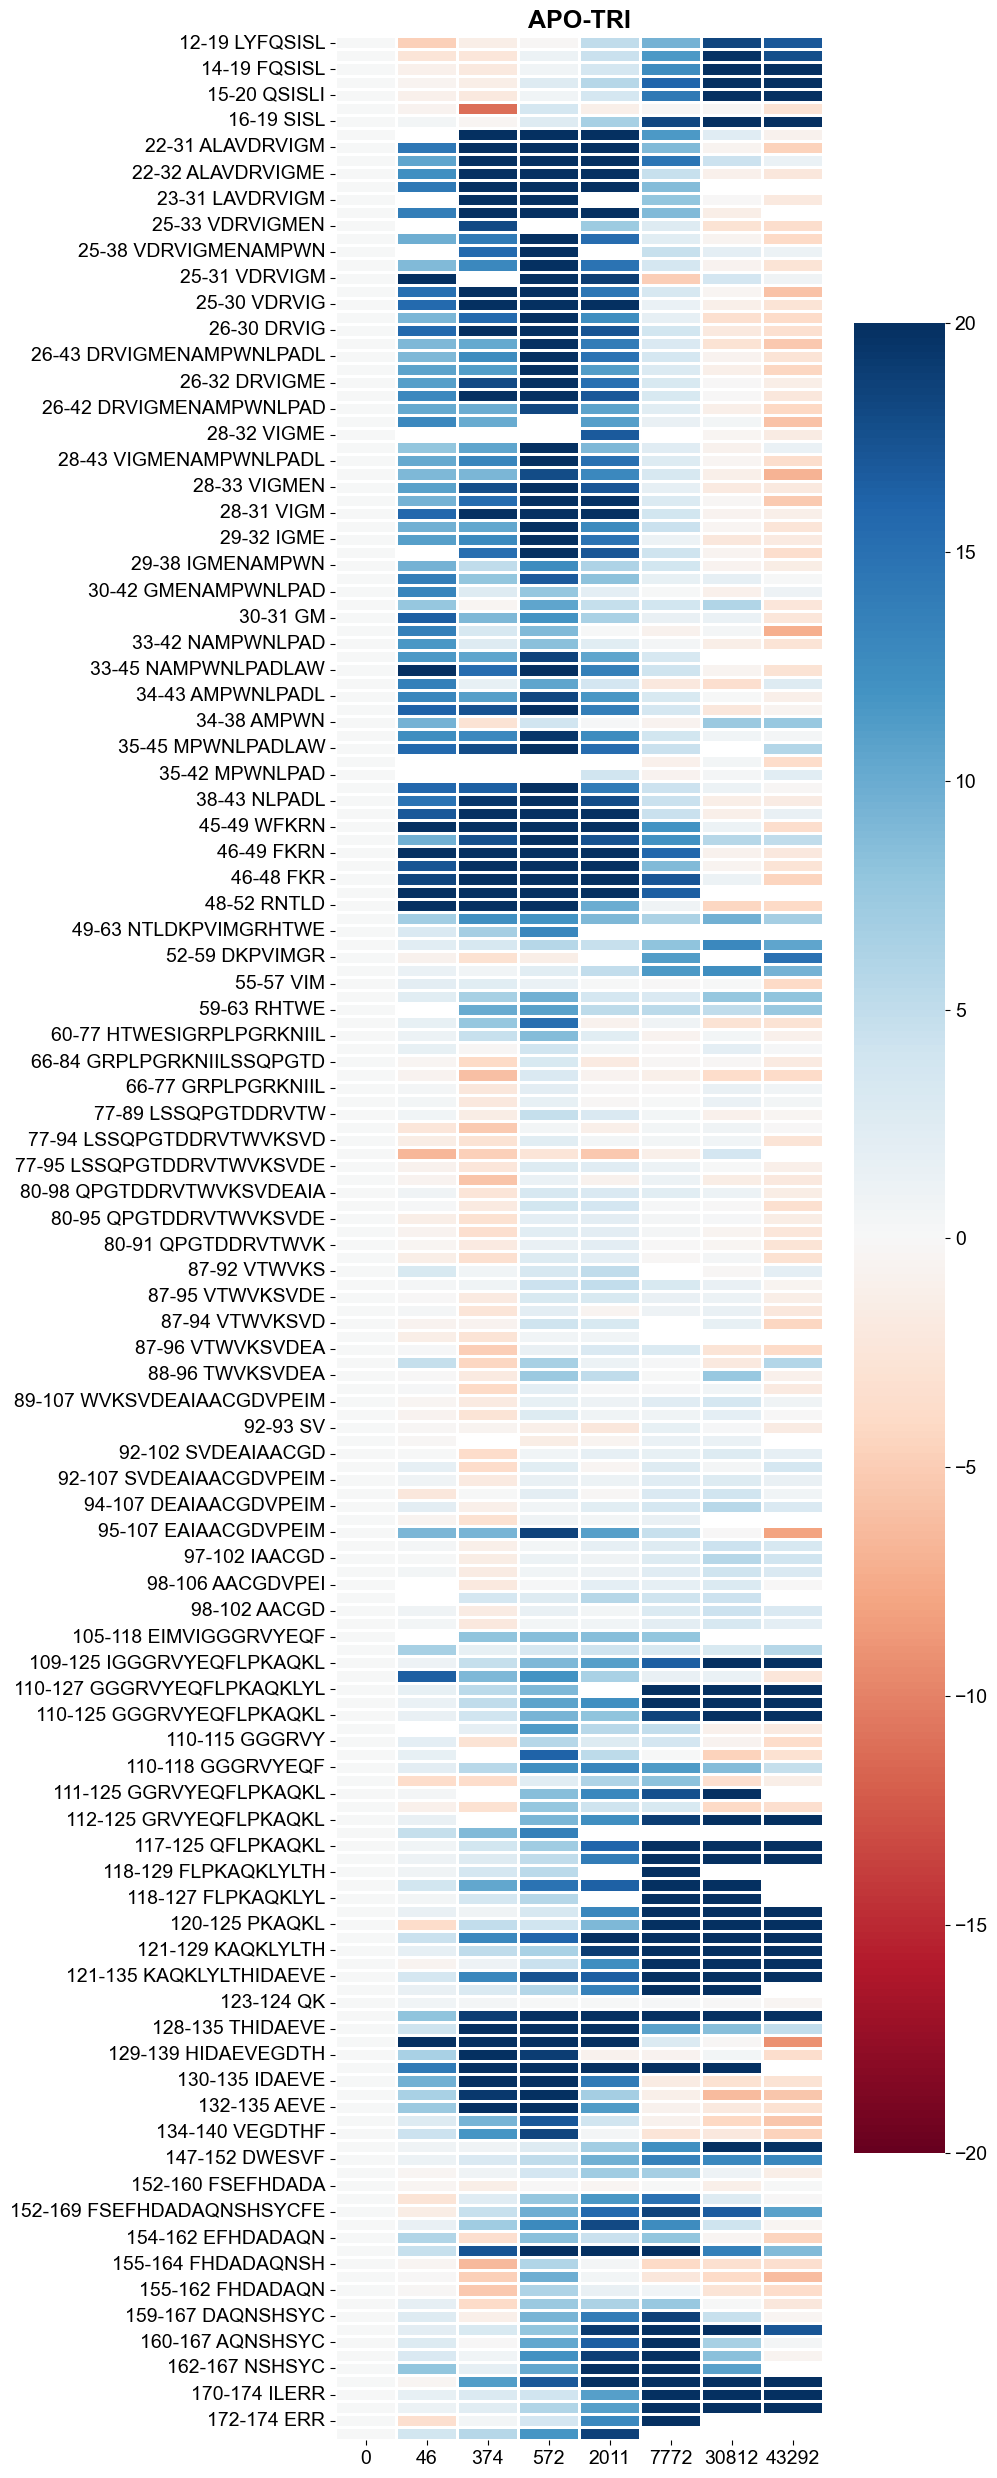

In [11]:
#  it can be visualized as a heatmap
create_heatmap_compare_tp(pep_compres, 20)

In [12]:
# make all the plots and save them

from itertools import product

items =[state.state_name for hdxms_data in hdxms_data_list for state in hdxms_data.states]
combinations = product(['APO'], [x for x in items if x != 'APO'])

for state1_name, state2_name in combinations:

    state1_list = [i.get_state(state1_name) for i in hdxms_data_list]
    state2_list = [i.get_state(state2_name) for i in hdxms_data_list]

    compare = HDXStatePeptideCompares(state1_list, state2_list)
    compare.add_all_compare()

    heatmap_compare_tp = create_heatmap_compare_tp(compare, 20)
    heatmap_compare_tp.savefig(f'{results_path}/{state1}-{state2}-heatmap-tp.png')

    heatmap_compare = create_heatmap_compare(compare, 20)
    heatmap_compare.savefig(f'{results_path}/{state1}-{state2}-heatmap.png')

    create_compare_pymol_plot(compare, colorbar_max=20, pdb_file=pdb_file, path=results_path)



    res_compares = HDXStateResidueCompares([i for i in range(1, 320)], state1_list, state2_list)
    res_compares.add_all_compare()

    create_compare_pymol_plot(res_compares, 20, pdb_file=pdb_file, path=results_path)